#  Positional Encoding

## 1. 自注意力的置换等变性（Permutation Equivariance）

### 1.1 置换等变性定义

若一个函数$f$满足：对任意输入序列$x=[x_1,x_2,\dots,x_n]$和任意位置置换$\sigma$(即$\sigma$ 是${1,2,\dots,n}$的一个排列)，有：

$$
f(x_{\sigma(1)},x_{\sigma(2)},\dots,x_{\sigma(n)}) = \sigma(f(x_1,x_2,\dots,x_n))
$$
则称$f$ 是置换等变的。

其中，$\sigma(f(x))$表示将函数$f$的输出按置换$\sigma$重新排列后的结果。

#

## 1.2 数学推导

自注意力机制的核心计算如下：

$$
\begin{align}
Q &= XW^Q, \\
K &= XW^K, \\
V &= XW^V, \\
\text{Attention}(Q,K,V) &= \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V.
\end{align}
$$

假设输入序列 $X = [x_1, x_2, \dots, x_n]$ 被置换为：
$$
X' = [x_{\sigma(1)}, x_{\sigma(2)}, \dots, x_{\sigma(n)}],
$$
则对应的查询、键、值矩阵变换为：

$$
Q' = X'W^Q = [x_{\sigma(1)}W^Q, \dots, x_{\sigma(n)}W^Q] = [Q_{\sigma(1)}, \dots, Q_{\sigma(n)}],
$$
$$
K' = X'W^K = [x_{\sigma(1)}W^K, \dots, x_{\sigma(n)}W^K] = [K_{\sigma(1)}, \dots, K_{\sigma(n)}],
$$
$$
V' = X'W^V = [x_{\sigma(1)}W^V, \dots, x_{\sigma(n)}W^V] = [V_{\sigma(1)}, \dots, V_{\sigma(n)}].
$$

由于 $Q, K, V$ 是通过对 $X$ 的线性变换得到的，当输入 $X$ 发生置换时，$Q', K', V'$ 也相应地以相同方式重排。这表明变换保持了输入的结构一致性。

考虑注意力分数的计算：

$$
Q'K'^T =
\left[ Q_{\sigma(1)}, \ldots, Q_{\sigma(n)} \right]
\left[ K_{\sigma(1)}, \ldots, K_{\sigma(n)} \right]^T
=
\begin{bmatrix}
Q_{\sigma(1)} K_{\sigma(1)}^T & \cdots & Q_{\sigma(1)} K_{\sigma(n)}^T \\
\vdots & \ddots & \vdots \\
Q_{\sigma(n)} K_{\sigma(1)}^T & \cdots & Q_{\sigma(n)} K_{\sigma(n)}^T
\end{bmatrix}.
$$

tips:$QK^T$存在结构对称性，即反应的元素关系是对称的，但值不一定完全相等，即$x_1.x_n = x_n.x_1$

注意到 $QK^T$ 中的每一项仅依赖于对应位置的特征 $x_i$ 和 $x_j$，而与它们在序列中的绝对位置无关。因此，置换后的注意力权重矩阵 $\text{softmax}\left(\frac{Q'K'^T}{\sqrt{d_k}}\right)$ 相当于原始权重矩阵 $\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)$ 的行列按相同置换 $\sigma$ 重排，记作：

$$
\text{softmax}\left(\frac{Q'K'^T}{\sqrt{d_k}}\right) = \left( \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right) \right)^{\sigma},
$$
其中上标 $\sigma$ 表示矩阵的行和列均按置换 $\sigma$ 重新排列。

最终，注意力输出为：

$$
\text{Attention}(Q',K',V') = \text{softmax}\left(\frac{Q'K'^T}{\sqrt{d_k}}\right) V' = \left( \text{Attention}(Q,K,V) \right)^{\sigma}.
$$

这表明：**当输入序列发生置换时，自注意力机制的输出也会以相同方式重排**，即满足**置换等变性（permutation equivariance）**。

## 2. Sinusoidal 位置编码

由于自注意力机制本身具有 **排列不变性（permutation invariance）**，无法感知序列中元素的相对位置，因此需要引入 **位置编码（Positional Encoding）**，以显式地为模型提供位置信息。

---

### 2.1 高维空间的正交假设

对于任意两个向量 $X$（嵌入向量）和 $P$（位置编码），其和的内积可展开为：
$$
\langle X + P, X + P \rangle = \|X\|^2 + 2\langle X, P \rangle + \|P\|^2.
$$
在高维空间中，若 $X$ 与 $P$ 近似正交性（$\langle X, P \rangle = 0$），则上式进一步简化为：
$$
\langle X + P, X + P \rangle = \|X\|^2 + \|P\|^2.
$$

---

### 2.2 公式定义

输入序列：$X \in \mathbb{R}^{n \times d}$（$n$ 个元素，每个元素 $d$ 维嵌入向量）。

位置编码矩阵：$P \in \mathbb{R}^{n \times d}$，其中第 $\text{pos}$ 行、第 $\text{dim}$ 列元素定义为：
$$
\begin{align}
P_{\text{pos}, 2i} &= \sin\left(\frac{\text{pos}}{10000^{\frac{2i}{d}}}\right), \\
P_{\text{pos}, 2i+1} &= \cos\left(\frac{\text{pos}}{10000^{\frac{2i}{d}}}\right).
\end{align}
$$

---

### 2.3 编码周期和频率特性

设角频率 $w_i = \frac{1}{10000^{\frac{2i}{d}}}$，则有：
$$
P_{\text{pos}, 2i} = \sin(w_i \cdot \text{pos}), \quad P_{\text{pos}, 2i+1} = \cos(w_i \cdot \text{pos}),
$$
对应的周期为：
$$
T_i = \frac{2\pi}{w_i} = 2\pi \cdot 10000^{\frac{2i}{d}}.
$$

#### 低维度（小 $i$ 值）- 高频特性

当 $i$ 较小时（如 $i=0$）：
$$
T_0 = 2\pi \cdot 10000^{0} = 2\pi.
$$
此时三角函数分量具有**高频、短周期**的特性，对位置变化敏感，能捕捉序列中**局部、精细的位置关系**。

#### 高维度（大 $i$ 值）- 低频特性

当 $i = \frac{d}{2}$ 时：
$$
T_{\frac{d}{2}} = 2\pi \cdot 10000^{\frac{2 \cdot \frac{d}{2}}{d}} = 2\pi \cdot 10000^{1} = 20000\pi.
$$
此时三角函数分量具有**低频、长周期**的特性，对位置变化不敏感，能捕捉序列中**长距离的位置关系**。

---

## 2.5 位置编码代码实现

In [2]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    """Sinusoidal位置编码"""
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # [max_len, 1]
        position = torch.arange(max_len).unsqueeze(1)

        # 计算频率衰减项：10000^(-2i/d_model) = exp(-2i/d_model * ln(10000))
        # i的范围：0 ≤ i < d_model/2（对应偶数维度 2i 和奇数维度 2i+1）
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )

        # 初始化位置编码矩阵
        pe = torch.zeros(max_len, d_model)  # [max_len, d_model]

        pe[:, 0::2] = torch.sin(position * div_term)  # 偶数维度：sin(pos * 10000^(-2i/d_model))
        pe[:, 1::2] = torch.cos(position * div_term)  # 奇数维度：cos(pos * 10000^(-2i/d_model))

        # 注册为缓冲区（不参与训练，仅存储）
        self.register_buffer('pe', pe.unsqueeze(0))  # [1, max_len, d_model]（广播维度）

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: 输入嵌入矩阵 [batch_size, seq_len, d_model]
        返回：添加位置编码后的嵌入矩阵 [batch_size, seq_len, d_model]
        """
        # 广播位置编码以匹配当前序列长度，并与输入嵌入相加
        x = x + self.pe[:, :x.size(1)]  # 广播机制自动适配批次和序列长度
        return self.dropout(x)

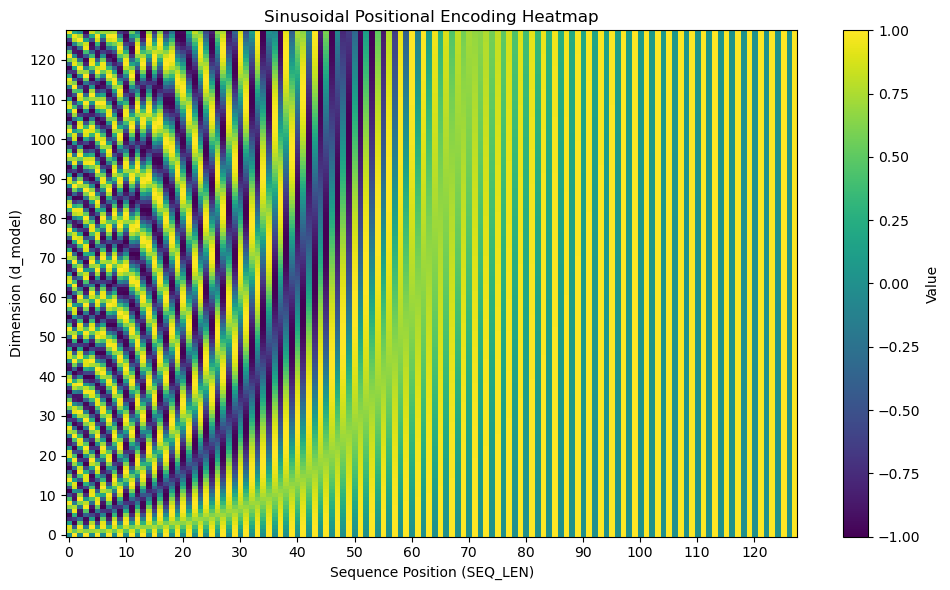

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch

d_model = 128
max_len = 128
dropout = 0.1

pe = PositionalEncoding(d_model=d_model, dropout=dropout, max_len=max_len)

def plot_position_encoding_heatmap():
    """绘制位置编码的热力图"""
    # 获取位置编码矩阵（形状：[max_len, d_model]）
    pe_np = pe.pe.squeeze(0).detach().numpy()

    plt.figure(figsize=(10, 6))

    plt.imshow(pe_np, aspect='auto', origin='lower', cmap='viridis', vmin=-1, vmax=1)
    plt.colorbar(label='Value')
    plt.ylabel('Dimension (d_model)')
    plt.xlabel('Sequence Position (SEQ_LEN)')
    plt.title('Sinusoidal Positional Encoding Heatmap')

    # 修正刻度范围：x轴为位置（0~max_len-1），y轴为维度（0~d_model-1）
    plt.xticks(range(0, max_len, 10), range(0, max_len, 10))  # x轴步长10，覆盖0~99
    plt.yticks(range(0, d_model, 10), range(0, d_model, 10))  # y轴步长10，覆盖0~127

    plt.tight_layout()
    plt.show()

plot_position_encoding_heatmap()

我们从图中可以得到：
- 同一维度上不同位置的编码值呈现周期性变化（颜色条纹的重复）
- 位置在低维维度（左半部分）：颜色变化剧烈（条纹细密、正负交替频繁）
- 位置在高维时（右半部分）：颜色变化缓慢（条纹稀疏）